# Authorship Prediction System Using Natural Language Processing

## Environment Setup

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import string
import re

# Natural Language Processing libraries
import nltk
nltk.download('gutenberg')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize 

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-learn Packages
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Import Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Preparation

In [2]:
# Function to remove punctuations and stopwords
def text_process(words):
    remove_punc = [char for char in words if char not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [3]:
# Creating a dataset with Gutenberg data from the NLTK package
np.random.seed(42)
tokenizer = RegexpTokenizer('\s+', gaps=True)
gut_files = nltk.corpus.gutenberg.fileids()
Sampling=[]
Records=[]
for file in gut_files:
    doc = ""
    labeled_docs = []
    count, j = 0, 0
    text = nltk.corpus.gutenberg.raw(file)
    tokenized_word = tokenizer.tokenize(text)

    for i, word in enumerate(tokenized_word):
        if(j < 101):
            if(re.search('\w',word) and word!=''):
                doc = doc +' '+ word
            else:
                doc = doc + word
            j = j + 1
        else:
            count= count + 1
            j = 0
            labeled_docs.append(doc)
            doc = word

    ser=pd.Series(labeled_docs)
    for i in ser.sample(200, replace=True).values:
        Sampling.append(i)
        Records.append(file)
df = pd.DataFrame(list(zip(Sampling,Records)), columns=["Data", "Target"])

# Length of each sample
df['Length'] = df['Data'].apply(len)

In [4]:
df.head()

,Data,Target,Length
0,"depend upon me,"" said she. ""I certainly will c...",austen-emma.txt,524
1,"the world, and only said, ""Is Mr. Elton gone o...",austen-emma.txt,541
2,"extremely well satisfied with herself, and thi...",austen-emma.txt,560
3,"not have thought it possible--But if _you_, wh...",austen-emma.txt,596
4,to have the table spread in the dining-room. T...,austen-emma.txt,544


## Data Transformations

### Bag-of-Words (BOW)

In [5]:
# Bag-of-Words
bow_fit = CountVectorizer(analyzer=text_process).fit(df['Data'])
bow_transform = bow_fit.transform(df['Data'])

In [6]:
print('Vocabulary Length: ', len(bow_fit.vocabulary_))
print('Vocabulary: ', bow_fit.vocabulary_.keys())
print('Shape of Sparse Matrix: ', bow_transform.shape)
print('Amount of Non-Zero occurences: ', bow_transform.nnz)

Vocabulary Length:  25702
Vocabulary:  dict_keys(['depend', 'upon', 'said', 'certainly', 'come', 'Name', 'day', 'allow', 'bring', 'Jane', 'Fairfax', 'cannot', 'name', 'till', 'spoken', 'others', 'would', 'wish', 'meet', 'Oh', 'leave', 'give', 'carteblancheI', 'Lady', 'Patroness', 'know', 'party', 'friends', 'hope', 'Elton', 'trouble', 'invitations', 'looking', 'sly', 'consideryou', 'need', 'world', 'Mr', 'gone', 'foot', 'DonwellHe', 'hot', 'walk', 'meeting', 'Crown', 'regular', 'Weston', 'Cole', 'one', 'apt', 'speak', 'leadI', 'fancy', 'E', 'Knightley', 'every', 'thing', 'way', 'mistaken', 'Emma', 'almost', 'certain', 'tomorrowMr', 'Hartfield', 'yesterday', 'spoke', 'Saturday', 'today', 'extremely', 'well', 'satisfied', 'thinking', 'much', 'importance', 'meant', 'shine', 'superior', 'manners', 'formed', 'bad', 'school', 'pert', 'familiar', 'notions', 'drawn', 'set', 'people', 'style', 'living', 'foolish', 'ignorant', 'society', 'good', 'Harriet', 'better', 'match', 'wise', 'refined', '

### Term Frequency Inverse Document Frequency (TF-IDF)

In [7]:
# TF-IDF
tfidf_transform = TfidfTransformer().fit(bow_transform)
tfidf = tfidf_transform.transform(bow_transform)

In [8]:
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': bow_fit.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False, inplace=True)
weights_df.head(20)

,Term,Weight
20903,said,0.022345
18243,one,0.015204
16745,little,0.015131
25551,would,0.014142
10850,could,0.013721
21429,shall,0.013400
16666,like,0.013153
16282,know,0.012282
17054,man,0.011972
23497,thou,0.011735


Text(0.5, 1.0, 'TF-IDF Top 20 Weights')

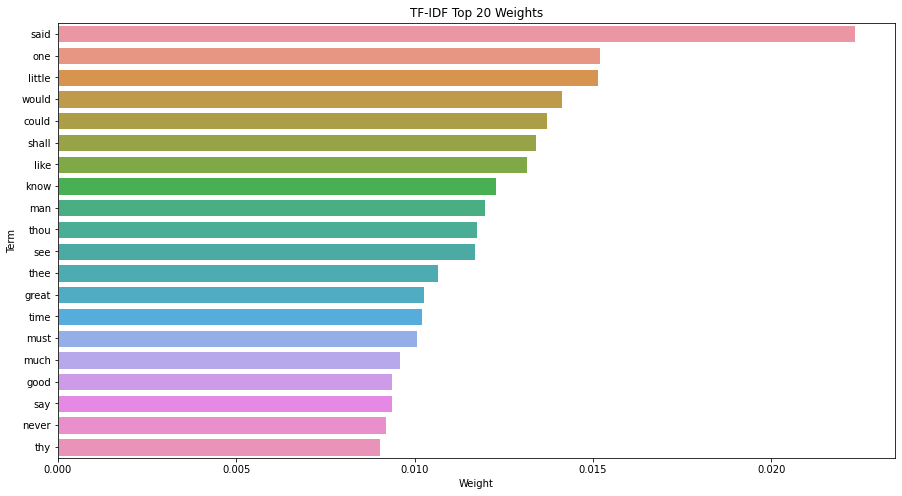

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
sns.set_theme(style="whitegrid")
sns.barplot(x=weights_df['Weight'][:20], y=weights_df['Term'][:20], ax=ax)
ax.set_title('TF-IDF Top 20 Weights')

## Machine Learning Experimentation

In [10]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['Data'], df['Target'], test_size=0.2, random_state=42)

# Dictionary of Machine Learning Models
models = {"RFC" : RandomForestClassifier(random_state=42),
          "SVM" : SVC(random_state=42),
          "KNN" : KNeighborsClassifier(),
          "MNB" : MultinomialNB(),
          "LogReg" : LogisticRegression()
          }

# Dictionary of pipelines
pipelines = {"BOW" : CountVectorizer(analyzer=text_process),
             "BOW + TFIDF" : Pipeline([('bow', CountVectorizer(analyzer=text_process)),
                                       ('tdif', TfidfTransformer())
                                       ]
                                      ),
             "BOW + StopWords" :  Pipeline([('bow', CountVectorizer())
                                            ]
                                           )
             }

In [11]:
np.random.seed(42)
def fit_and_score(models, X_train, y_train, X_test, y_test, pipelines):
    '''
    Fits and evaluates the machine learning models with only BOW in pipeline.
    models : a dict of different Scikit-Learn machine learning models.
    X_train : training data (no labels)
    y_train : training lables
    X_test : testing data (no labels)
    y_test : testing lables
    Returns Model Scores and Predictions as Dictionary
    '''
    model_scores = {}
    predictions = {}
    mode_scores_train = {}
    model_scores_avg = {}
    for name, model in models.items():
      pipeline = Pipeline([('pipe', pipelines),
                           ('model', model)
                           ]
                          )
      pipeline.fit(X_train, y_train)
      predictions[name] = pipeline.predict(X_test) 
      model_scores[name] =  cross_val_score(pipeline, X_test, y_test, cv=5, scoring="accuracy") # 10-Fold Cross-Validation pipeline.score(X_test, y_test)
      mode_scores_train[name] = pipeline.score(X_train, y_train)
    for name, score in model_scores.items():
      model_scores_avg[name] = np.mean(score)
    return {'avg_scores': model_scores_avg, 
            'prediction': predictions, 
            'train_score': mode_scores_train
            }

In [12]:
%%time
np.random.seed(42)
results = {}
for name, pipe in pipelines.items():
  results[name] = fit_and_score(models, X_train, y_train, X_test, y_test, pipe)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


CPU times: user 17min 53s, sys: 2min 49s, total: 20min 42s
Wall time: 19min 52s


In [13]:
# Cross-Validated Testing Accuracy
bow_accuracy_df = pd.DataFrame(results['BOW']['avg_scores'], index=['BOW'])
bow_tfidf_accuracy_df = pd.DataFrame(results['BOW + TFIDF']['avg_scores'], index=['BOW + TFIDF'])
bow_stop_accuracy_df = pd.DataFrame(results['BOW + StopWords']['avg_scores'], index=['BOW + StopWords'])
acc_df = pd.concat([bow_accuracy_df, bow_tfidf_accuracy_df, bow_stop_accuracy_df])

# Training Scores
bow_accuracy_df_train = pd.DataFrame(results['BOW']['train_score'], index=['BOW Training'])
bow_tfidf_accuracy_df_train = pd.DataFrame(results['BOW + TFIDF']['train_score'], index=['BOW + TFIDF'])
bow_stop_accuracy_df_train = pd.DataFrame(results['BOW + StopWords']['train_score'], index=['BOW + StopWords'])
acc_df_train = pd.concat([bow_accuracy_df_train, bow_tfidf_accuracy_df_train, bow_stop_accuracy_df_train])

In [14]:
acc_df

,RFC,SVM,KNN,MNB,LogReg
BOW,0.736111,0.516667,0.272222,0.777778,0.765278
BOW + TFIDF,0.752778,0.591667,0.645833,0.693056,0.766667
BOW + StopWords,0.741667,0.554167,0.351389,0.691667,0.702778


In [15]:
acc_df_train

,RFC,SVM,KNN,MNB,LogReg
BOW Training,1.0,0.999653,0.581250,0.999306,1.000000
BOW + TFIDF,1.0,1.000000,0.853819,0.997917,0.999653
BOW + StopWords,1.0,0.985764,0.692014,0.995486,1.000000


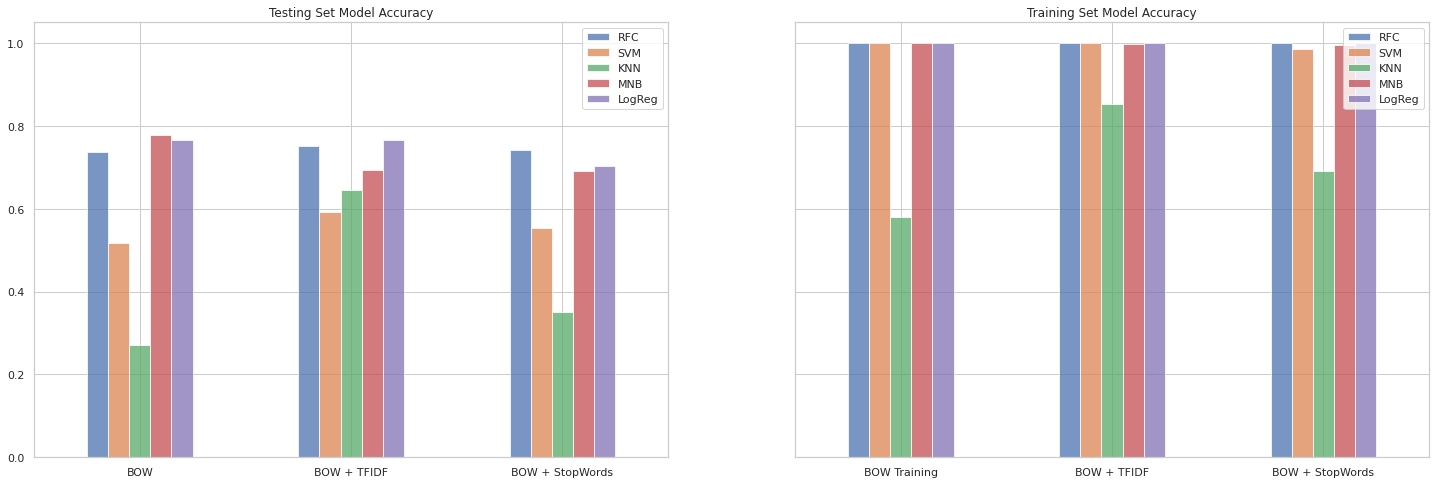

In [16]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(25,8))
acc_df.plot(kind='bar', title="Testing Set Model Accuracy", alpha=0.75, rot=0, ax=ax1)
acc_df_train.plot(kind='bar', title="Training Set Model Accuracy", alpha=0.75, rot=0, ax=ax2)

In [17]:
# RFC -> BOW + StopWords
# LogReg -> BOW + TfidfTransformer
# MNB -> BOW